## Linear and Quadratic Discriminant Analysis with confidence ellipsoid
## 線性判別對比上二次判別

http://scikit-learn.org/stable/auto_examples/classification/plot_lda_qda.html



## (一)資料產生function

這個範例引入的套件，主要特點在：
1. `scipy.linalg`:線性代數相關函式，這裏主要使用到linalg.eigh 特徵值相關問題
2. `matplotlib.colors`: 用來處理繪圖時的色彩分佈
3. `LinearDiscriminantAnalysis`:線性判別演算法
4. `QuadraticDiscriminantAnalysis`:二次判別演算法

In [ ]:
%matplotlib inline
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

接下來是設定一個線性變化的colormap，`LinearSegmentedColormap(name, segmentdata)` 預設會傳回一個256個值的數值顏色對應關係。用一個具備有三個項目的dict變數`segmentdata`來設定。以`'red': [(0, 1, 1), (1, 0.7, 0.7)]`來解釋，就是我們希望數值由0到1的過程，紅色通道將由1線性變化至0.7。

In [67]:
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)

我們可以用以下程式碼來觀察。當輸入數值為`np.arange(0,1.1,0.1)`也就是0,0.1...,1.0 時RGB數值的變化情形。

In [68]:
values = np.arange(0,1.1,0.1)
cmap_values = mpl.cm.get_cmap('red_blue_classes')(values)
import pandas as pd
pd.set_option('precision',2)
df=pd.DataFrame(np.hstack((values.reshape(11,1),cmap_values)))
df.columns = ['Value', 'R', 'G', 'B', 'Alpha']
print(df)

    Value     R    G     B  Alpha
0     0.0  1.00  0.7  0.70      1
1     0.1  0.97  0.7  0.73      1
2     0.2  0.94  0.7  0.76      1
3     0.3  0.91  0.7  0.79      1
4     0.4  0.88  0.7  0.82      1
5     0.5  0.85  0.7  0.85      1
6     0.6  0.82  0.7  0.88      1
7     0.7  0.79  0.7  0.91      1
8     0.8  0.76  0.7  0.94      1
9     0.9  0.73  0.7  0.97      1
10    1.0  0.70  0.7  1.00      1


接著我們產生兩組資料, 每組資料有 600筆資料，2個特徵 `X: 600x2`：
1. 具備有相同共變數(covariance)
2. 具備有不同之共變數

In [15]:
def dataset_fixed_cov():
    '''Generate 2 Gaussians samples with the same covariance matrix'''
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -0.23], [0.83, .23]])
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C) + np.array([1, 1])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y

def dataset_cov():
    '''Generate 2 Gaussians samples with different covariance matrices'''
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -1.], [2.5, .7]]) * 2.
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C.T) + np.array([1, 4])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y

In [69]:
n, dim = 300, 2
np.random.seed(0)
C = np.array([[0., -0.23], [0.83, .23]])
X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C) + np.array([1, 1])]
y = np.hstack((np.zeros(n), np.ones(n)))


(300L, 2L)

## (二)繪圖函式

In [16]:
def plot_data(lda, X, y, y_pred, fig_index):
    splot = plt.subplot(2, 2, fig_index)
    if fig_index == 1:
        plt.title('Linear Discriminant Analysis',fontsize=28)
        plt.ylabel('Data with fixed covariance',fontsize=28)
    elif fig_index == 2:
        plt.title('Quadratic Discriminant Analysis',fontsize=28)
    elif fig_index == 3:
        plt.ylabel('Data with varying covariances',fontsize=28)

    tp = (y == y_pred)  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.plot(X0_tp[:, 0], X0_tp[:, 1], 'o', color='red')
    plt.plot(X0_fp[:, 0], X0_fp[:, 1], '.', color='#990000')  # dark red

    # class 1: dots
    plt.plot(X1_tp[:, 0], X1_tp[:, 1], 'o', color='blue')
    plt.plot(X1_fp[:, 0], X1_fp[:, 1], '.', color='#000099')  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
                   norm=colors.Normalize(0., 1.))
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='k')

    # means
    plt.plot(lda.means_[0][0], lda.means_[0][1],
             'o', color='black', markersize=10)
    plt.plot(lda.means_[1][0], lda.means_[1][1],
             'o', color='black', markersize=10)

    return splot


def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())

## (三)測試資料並繪圖

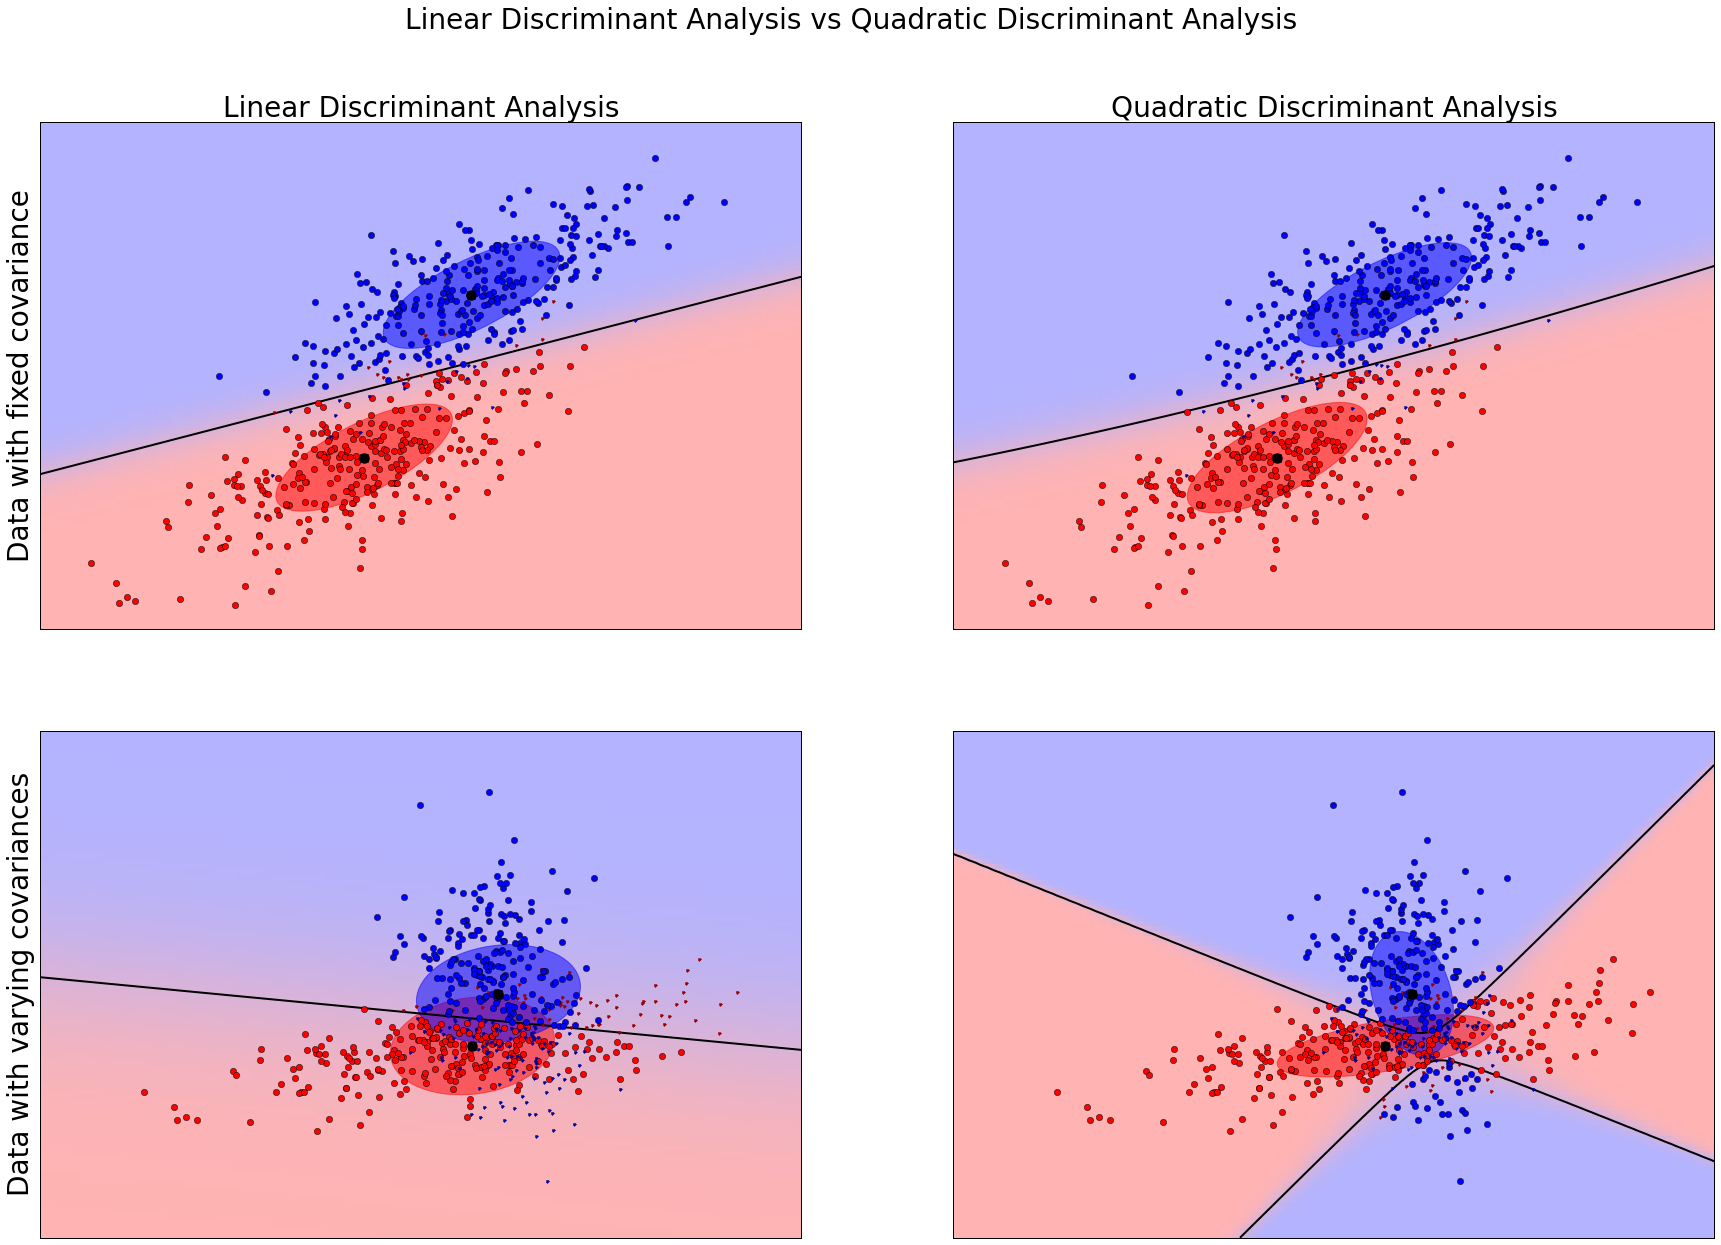

In [17]:
def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, 'red')
    plot_ellipse(splot, lda.means_[1], lda.covariance_, 'blue')


def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariances_[0], 'red')
    plot_ellipse(splot, qda.means_[1], qda.covariances_[1], 'blue')

###############################################################################
figure = plt.figure(figsize=(30,20), dpi=300)
for i, (X, y) in enumerate([dataset_fixed_cov(), dataset_cov()]):
    # Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
    y_pred = lda.fit(X, y).predict(X)
    splot = plot_data(lda, X, y, y_pred, fig_index=2 * i + 1)
    plot_lda_cov(lda, splot)
    plt.axis('tight')

    # Quadratic Discriminant Analysis
    qda = QuadraticDiscriminantAnalysis(store_covariances=True)
    y_pred = qda.fit(X, y).predict(X)
    splot = plot_data(qda, X, y, y_pred, fig_index=2 * i + 2)
    plot_qda_cov(qda, splot)
    plt.axis('tight')
plt.suptitle('Linear Discriminant Analysis vs Quadratic Discriminant Analysis',fontsize=28)
plt.show()

Python source code: plot_lda_qda.py

http://scikit-learn.org/stable/_downloads/plot_lda_qda.py

In [ ]:
print(__doc__)

from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

###############################################################################
# colormap
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)


###############################################################################
# generate datasets
def dataset_fixed_cov():
    '''Generate 2 Gaussians samples with the same covariance matrix'''
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -0.23], [0.83, .23]])
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C) + np.array([1, 1])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y


def dataset_cov():
    '''Generate 2 Gaussians samples with different covariance matrices'''
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -1.], [2.5, .7]]) * 2.
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C.T) + np.array([1, 4])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y


###############################################################################
# plot functions
def plot_data(lda, X, y, y_pred, fig_index):
    splot = plt.subplot(2, 2, fig_index)
    if fig_index == 1:
        plt.title('Linear Discriminant Analysis')
        plt.ylabel('Data with fixed covariance')
    elif fig_index == 2:
        plt.title('Quadratic Discriminant Analysis')
    elif fig_index == 3:
        plt.ylabel('Data with varying covariances')

    tp = (y == y_pred)  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.plot(X0_tp[:, 0], X0_tp[:, 1], 'o', color='red')
    plt.plot(X0_fp[:, 0], X0_fp[:, 1], '.', color='#990000')  # dark red

    # class 1: dots
    plt.plot(X1_tp[:, 0], X1_tp[:, 1], 'o', color='blue')
    plt.plot(X1_fp[:, 0], X1_fp[:, 1], '.', color='#000099')  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
                   norm=colors.Normalize(0., 1.))
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='k')

    # means
    plt.plot(lda.means_[0][0], lda.means_[0][1],
             'o', color='black', markersize=10)
    plt.plot(lda.means_[1][0], lda.means_[1][1],
             'o', color='black', markersize=10)

    return splot


def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())


def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, 'red')
    plot_ellipse(splot, lda.means_[1], lda.covariance_, 'blue')


def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariances_[0], 'red')
    plot_ellipse(splot, qda.means_[1], qda.covariances_[1], 'blue')

###############################################################################
for i, (X, y) in enumerate([dataset_fixed_cov(), dataset_cov()]):
    # Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
    y_pred = lda.fit(X, y).predict(X)
    splot = plot_data(lda, X, y, y_pred, fig_index=2 * i + 1)
    plot_lda_cov(lda, splot)
    plt.axis('tight')

    # Quadratic Discriminant Analysis
    qda = QuadraticDiscriminantAnalysis(store_covariances=True)
    y_pred = qda.fit(X, y).predict(X)
    splot = plot_data(qda, X, y, y_pred, fig_index=2 * i + 2)
    plot_qda_cov(qda, splot)
    plt.axis('tight')
plt.suptitle('Linear Discriminant Analysis vs Quadratic Discriminant Analysis')
plt.show()